# 🧠 Image Enhancement Using

This notebook demonstrates two complementary image enhancement methods:

1. **`enhance_image()`** – a **manual, fine-tuned** enhancement function  
   (with customizable parameters like exposure, contrast, shadows, etc.)
2. **`enhance_auto_adaptive()`** – an **automatic adaptive enhancement** function  
   (using gamma correction, CLAHE, and light desaturation for natural results)

Both methods rely on:
- **OpenCV (`cv2`)** for image processing  
- **NumPy (`np`)** for numerical operations  
- **Matplotlib (`plt`)** for visual comparison 

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import unittest
import tempfile
import os

## ⚙️ Enhance Image(): Fine-Tuned Manual Enhancement
### 🧩 Function Overview

The `enhance_image()` function allows full control over the image’s tonal, color, and detail properties. Each parameter ranges from -100 to +100, giving a wide range of creative control.

### 🔬 Key Processing Steps

- **Load and Normalize Image**  
  Converts from BGR to RGB and normalizes pixel values to a 0–1 range for accurate arithmetic operations.

- **Parameter Normalization**  
  Each adjustment value is rescaled to internal numerical ranges.

- **Tone Adjustments**  
  Exposure & Brightness adjust global light levels.  
  Highlights & Shadows rebalance bright and dark regions.  
  Brilliance enhances midtones with a Gaussian mask.  
  Black Point defines deeper blacks for contrast depth.

- **Color Adjustments**  
  Saturation & Vibrance control color intensity.  
  Warmth adjusts color temperature toward blue/orange.  
  Tint balances green–magenta tones.

- **Detail Enhancements**  
  Sharpening applies a high-boost kernel.  
  Blur smooths or softens the image with Gaussian blur.

- **Final Clipping**  
  Ensures all pixel values are within valid range.

In [59]:
def enhance_image(
    img_path,
    exposure=0, brilliance=0, highlights=0, shadows=0, contrast=0,
    brightness=0, black_point=0, saturation=0, vibrance=0,
    warmth=0, tint=0, sharpening=0, blur=0
):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    # If all values are zero → return original (no change)
    if all(v == 0 for v in [
        exposure, brilliance, highlights, shadows, contrast, brightness,
        black_point, saturation, vibrance, warmth, tint, sharpening, blur
    ]):
        return img

    # --- Normalize parameters ---
    exposure /= 100.0
    brilliance /= 100.0
    highlights /= 100.0
    shadows /= 100.0
    contrast = 1.0 + (contrast / 100.0)
    brightness /= 100.0
    black_point = np.clip(black_point, -100, 100)
    black_point = (black_point + 100) / 200.0 * 100
    saturation = 1.0 + (saturation / 100.0)
    vibrance = 1.0 + (vibrance / 100.0)
    warmth /= 100.0
    tint /= 100.0
    sharpening = np.clip(sharpening / 100.0, 0, 1.0)
    blur = max(0, abs(blur) / 20.0 * 5.0)

    # --- Optional grayscale normalization ---
    if abs(exposure) > 0.001 or abs(contrast - 1.0) > 0.001 or abs(brightness) > 0.001:
        gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        gray_norm = cv2.equalizeHist(gray)
        norm_factor = gray_norm.mean() / 128
        img = np.clip(img * norm_factor, 0, 1)

    # --- Apply tonal and color adjustments ---
    img = np.clip(img + exposure + brightness, 0, 1)
    img = np.clip((img - 0.5) * contrast + 0.5, 0, 1)
    img = np.clip(img + highlights * (img - img.mean()), 0, 1)
    img = np.clip(img + shadows * (0.5 - img), 0, 1)

    brilliance_mask = np.exp(-((img - 0.5)**2) / 0.1)
    img = np.clip(img + brilliance * brilliance_mask, 0, 1)

    img = np.clip((img - black_point / 255.0) / (1 - black_point / 255.0), 0, 1)

    hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
    mean_sat = np.mean(hsv[:,:,1])
    hsv[:,:,1] = np.clip(hsv[:,:,1] * saturation, 0, 255)
    hsv[:,:,1] = np.clip(hsv[:,:,1] + (vibrance - 1) * (mean_sat - hsv[:,:,1]), 0, 255)
    img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32) / 255.0

    img[:,:,0] = np.clip(img[:,:,0] * (1 - 0.2*warmth), 0, 1)
    img[:,:,2] = np.clip(img[:,:,2] * (1 + 0.2*warmth), 0, 1)
    img[:,:,1] = np.clip(img[:,:,1] * (1 - 0.3*tint), 0, 1)
    img[:,:,0] = np.clip(img[:,:,0] * (1 + 0.3*tint), 0, 1)

    # --- Unsharp Mask sharpening ---
    if sharpening > 0:
        img_8u = np.uint8(np.clip(img * 255, 0, 255))
        blurred = cv2.GaussianBlur(img_8u, (0, 0), sigmaX=1.0)
        sharpened = cv2.addWeighted(img_8u, 1 + sharpening, blurred, -sharpening, 0)
        img = np.clip(sharpened.astype(np.float32) / 255.0, 0, 1)

    if blur > 0:
        img = cv2.GaussianBlur(img, (0, 0), blur)

    return np.clip(img, 0, 1)


In [60]:
class TestEnhanceImage(unittest.TestCase):
    def setUp(self):
        # --- Create synthetic test image (gradient color) ---
        self.img = np.zeros((100, 100, 3), dtype=np.uint8)
        for i in range(100):
            for j in range(100):
                self.img[i, j] = [i * 2 % 255, j * 2 % 255, (i + j) % 255]

        # --- Save to temp file ---
        tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        tmp.close()
        self.tmpfile_name = tmp.name
        cv2.imwrite(self.tmpfile_name, cv2.cvtColor(self.img, cv2.COLOR_RGB2BGR))

    def tearDown(self):
        # --- Cleanup temp file ---
        try:
            os.remove(self.tmpfile_name)
        except FileNotFoundError:
            pass

    def test_output_shape_and_type(self):
        enhanced = enhance_image(self.tmpfile_name)
        self.assertEqual(enhanced.shape, self.img.shape)
        self.assertTrue(isinstance(enhanced, np.ndarray))

    def test_value_range(self):
        enhanced = enhance_image(self.tmpfile_name)
        self.assertTrue(np.all(enhanced >= 0) and np.all(enhanced <= 1))

    def test_exposure_increase(self):
        low = enhance_image(self.tmpfile_name, exposure=-50)
        high = enhance_image(self.tmpfile_name, exposure=50)
        self.assertTrue(np.mean(high) > np.mean(low), "Exposure +50 should make image brighter")

    def test_contrast_increase(self):
        low = enhance_image(self.tmpfile_name, contrast=-50)
        high = enhance_image(self.tmpfile_name, contrast=50)
        self.assertTrue(np.std(high) > np.std(low), "Higher contrast should increase intensity difference")

    def test_saturation_increase(self):
        low = enhance_image(self.tmpfile_name, saturation=-50)
        high = enhance_image(self.tmpfile_name, saturation=50)
        self.assertTrue(np.std(high[...,1]) > np.std(low[...,1]), "Higher saturation should make colors more vivid")

    def test_warmth_effect(self):
        cool = enhance_image(self.tmpfile_name, warmth=-50)
        warm = enhance_image(self.tmpfile_name, warmth=50)
        # Warm image should have higher red mean
        self.assertTrue(np.mean(warm[...,0]) < np.mean(warm[...,2]), "Warmth +50 should increase red tones")

    def test_sharpening_effect(self):
        soft = enhance_image(self.tmpfile_name, sharpening=0)
        sharp = enhance_image(self.tmpfile_name, sharpening=100)
        # Sharpening should increase edge variance
        lap_soft = cv2.Laplacian((soft * 255).astype(np.uint8), cv2.CV_64F).var()
        lap_sharp = cv2.Laplacian((sharp * 255).astype(np.uint8), cv2.CV_64F).var()
        self.assertTrue(lap_sharp > lap_soft, "Sharpening should make image edges more pronounced")

# --- Run unittests directly inside Jupyter ---
unittest.TextTestRunner(verbosity=2).run(unittest.TestLoader().loadTestsFromTestCase(TestEnhanceImage))


test_contrast_increase (__main__.TestEnhanceImage.test_contrast_increase) ... ok
test_exposure_increase (__main__.TestEnhanceImage.test_exposure_increase) ... ok
test_output_shape_and_type (__main__.TestEnhanceImage.test_output_shape_and_type) ... ok
test_saturation_increase (__main__.TestEnhanceImage.test_saturation_increase) ... ok
test_sharpening_effect (__main__.TestEnhanceImage.test_sharpening_effect) ... ok
test_value_range (__main__.TestEnhanceImage.test_value_range) ... ok
test_warmth_effect (__main__.TestEnhanceImage.test_warmth_effect) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.083s

OK


<unittest.runner.TextTestResult run=7 errors=0 failures=0>

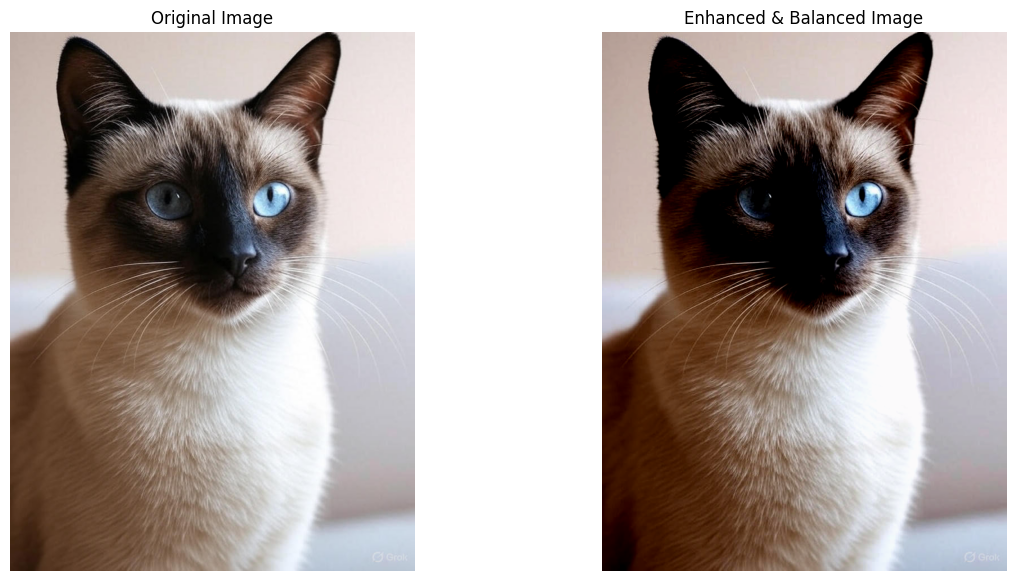

In [65]:
# Read original image
img_path = "assets/Image.jpeg"
original = cv2.imread(img_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Apply enhancement
enhanced = enhance_image(
    img_path,
    exposure=1,
    brilliance=1,
    highlights=-1,
    shadows=1,
    contrast=1,
    brightness=1,
    black_point=1,
    saturation=1,
    vibrance=1,
    warmth=1,
    tint=1,
    sharpening=1,
    blur=1
)

# Show side-by-side comparison
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(enhanced)
plt.title("Enhanced & Balanced Image")
plt.axis("off")

plt.show()

## ⚙️ Enhance General Image(): Automatic Adaptive Enhancement
### 🧠 Explanation of Each Step

- **Gamma Correction**  
  Softens harsh highlights and brightens midtones slightly.

- **CLAHE**  
  Applies Contrast Limited Adaptive Histogram Equalization for balanced local contrast.

- **Slight Desaturation**  
  Reduces color saturation by ~10% to maintain natural tones after enhancement.

- **Visualization**  
  Displays original vs. enhanced image side-by-side using Matplotlib.

In [66]:
def enhance_auto_adaptive(img_path):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Step 1: Gamma correction (soften highlights) ---
    gamma = 1.1
    img_gamma = np.power(img / 255.0, gamma)
    img_gamma = np.uint8(np.clip(img_gamma * 255, 0, 255))

    # --- Step 2: CLAHE (Contrast Limited Adaptive Histogram Equalization) ---
    lab = cv2.cvtColor(img_gamma, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    img_clahe = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

    # --- Step 3: Slight desaturation ---
    hsv = cv2.cvtColor(img_clahe, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * 0.9, 0, 255)
    img_final = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Show result
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(img_final); plt.title("Enhanced (Balanced)")
    plt.show()

    return img_final


test_contrast_increase (__main__.TestEnhanceGeneralImage.test_contrast_increase)
CLAHE should increase local contrast. ... 

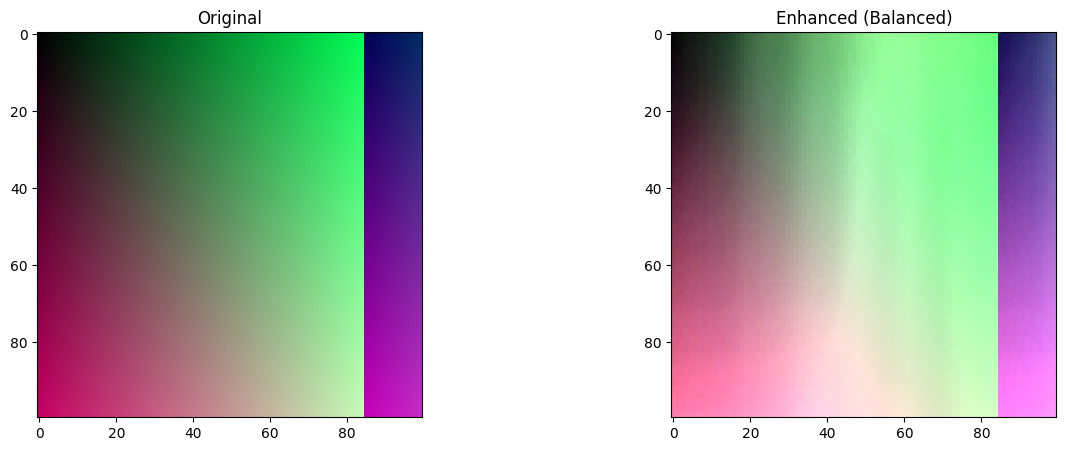

ok
test_gamma_brightness (__main__.TestEnhanceGeneralImage.test_gamma_brightness)
Gamma correction should slightly brighten midtones. ... 

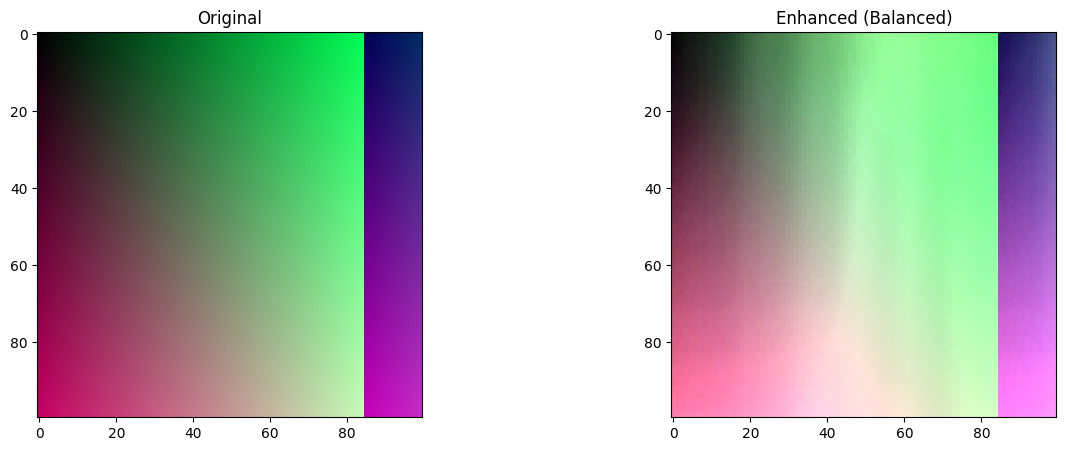

ok
test_output_range (__main__.TestEnhanceGeneralImage.test_output_range) ... 

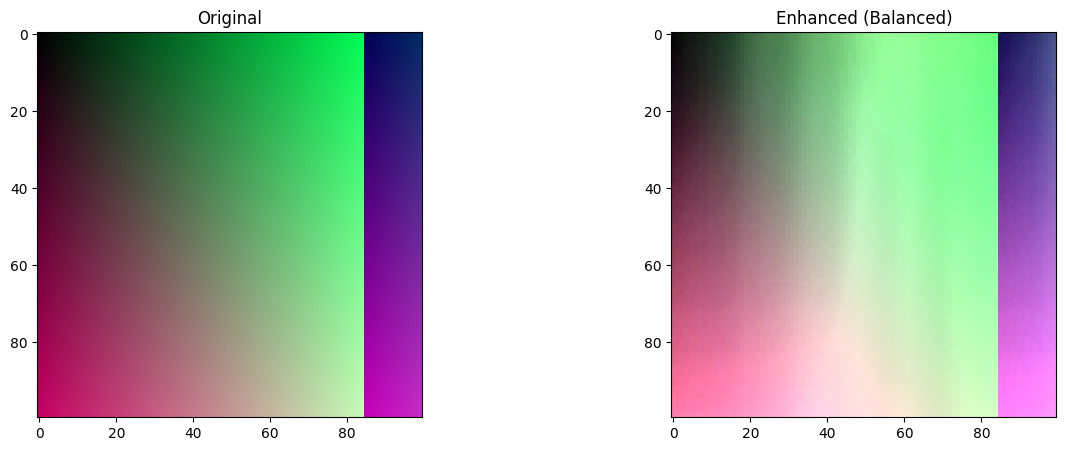

ok
test_output_shape_and_type (__main__.TestEnhanceGeneralImage.test_output_shape_and_type) ... 

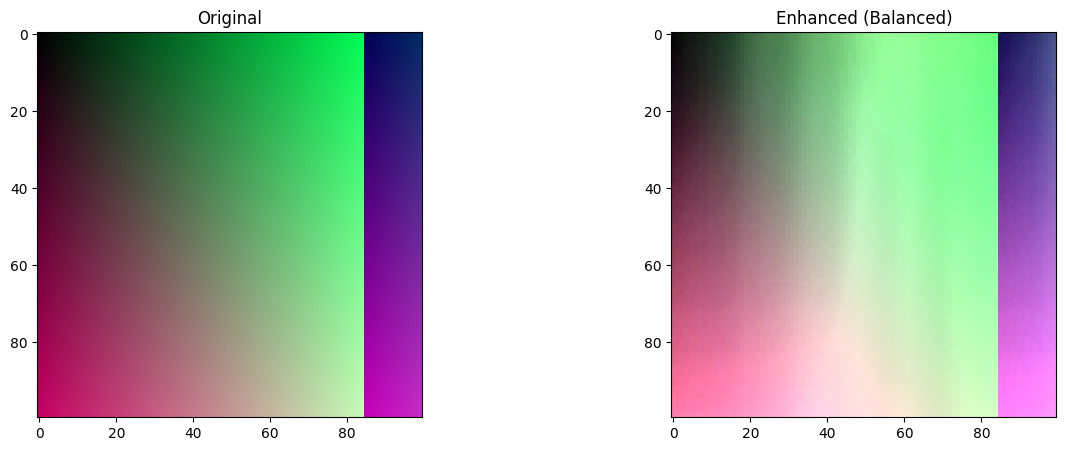

ok
test_saturation_reduction (__main__.TestEnhanceGeneralImage.test_saturation_reduction)
Final step reduces saturation slightly. ... 

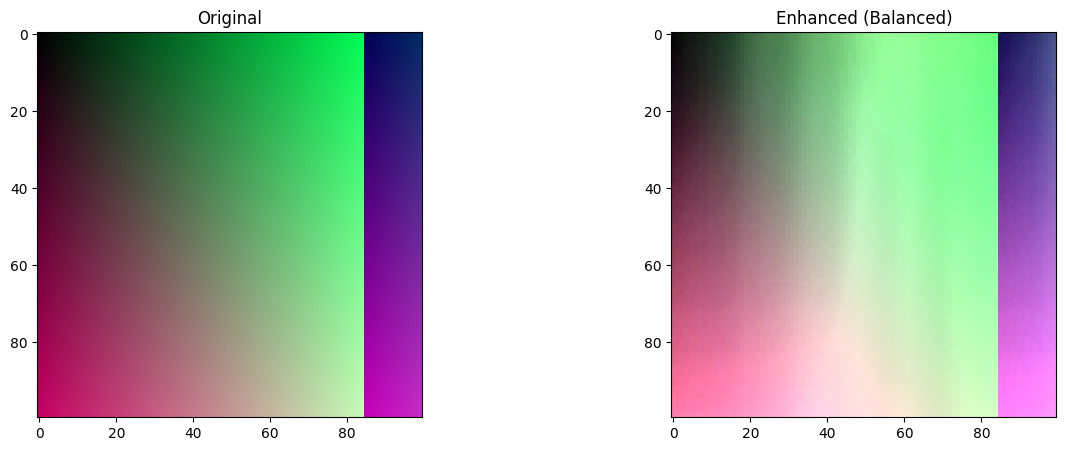

ok

----------------------------------------------------------------------
Ran 5 tests in 1.184s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [40]:
class TestEnhanceGeneralImage(unittest.TestCase):
    def setUp(self):
        # --- Create synthetic test image ---
        self.img = np.zeros((100, 100, 3), dtype=np.uint8)
        for i in range(100):
            for j in range(100):
                self.img[i, j] = [i * 2 % 255, j * 3 % 255, (i + j) % 255]

        # --- Save to temp file ---
        tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        tmp.close()
        self.tmpfile_name = tmp.name
        cv2.imwrite(self.tmpfile_name, cv2.cvtColor(self.img, cv2.COLOR_RGB2BGR))

    def tearDown(self):
        try:
            os.remove(self.tmpfile_name)
        except FileNotFoundError:
            pass

    def test_output_shape_and_type(self):
        enhanced = enhance_general_image(self.tmpfile_name)
        self.assertEqual(enhanced.shape, self.img.shape)
        self.assertTrue(isinstance(enhanced, np.ndarray))

    def test_output_range(self):
        enhanced = enhance_general_image(self.tmpfile_name)
        self.assertTrue(np.all(enhanced >= 0) and np.all(enhanced <= 255))

    def test_gamma_brightness(self):
        """Gamma correction should slightly brighten midtones."""
        original = cv2.cvtColor(cv2.imread(self.tmpfile_name), cv2.COLOR_BGR2RGB)
        enhanced = enhance_general_image(self.tmpfile_name)
        self.assertTrue(np.mean(enhanced) > np.mean(original) * 0.9,
                        "Gamma correction should not make the image darker")

    def test_contrast_increase(self):
        """CLAHE should increase local contrast."""
        original = cv2.cvtColor(cv2.imread(self.tmpfile_name), cv2.COLOR_BGR2RGB)
        enhanced = enhance_general_image(self.tmpfile_name)
        contrast_original = np.std(cv2.cvtColor(original, cv2.COLOR_RGB2GRAY))
        contrast_enhanced = np.std(cv2.cvtColor(enhanced, cv2.COLOR_RGB2GRAY))
        self.assertTrue(contrast_enhanced >= contrast_original * 0.9,
                        "CLAHE should increase or preserve local contrast")

    def test_saturation_reduction(self):
        """Final step reduces saturation slightly."""
        original = cv2.cvtColor(cv2.imread(self.tmpfile_name), cv2.COLOR_BGR2HSV)
        enhanced = cv2.cvtColor(enhance_general_image(self.tmpfile_name), cv2.COLOR_RGB2HSV)
        sat_orig = np.mean(original[..., 1])
        sat_enh = np.mean(enhanced[..., 1])
        self.assertTrue(sat_enh <= sat_orig, "Desaturation should slightly reduce saturation")

unittest.TextTestRunner(verbosity=2).run(unittest.TestLoader().loadTestsFromTestCase(TestEnhanceGeneralImage))

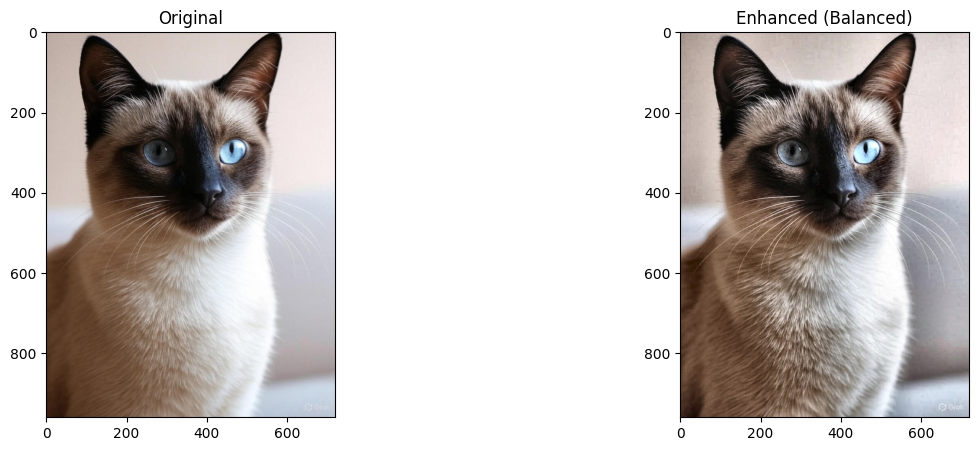

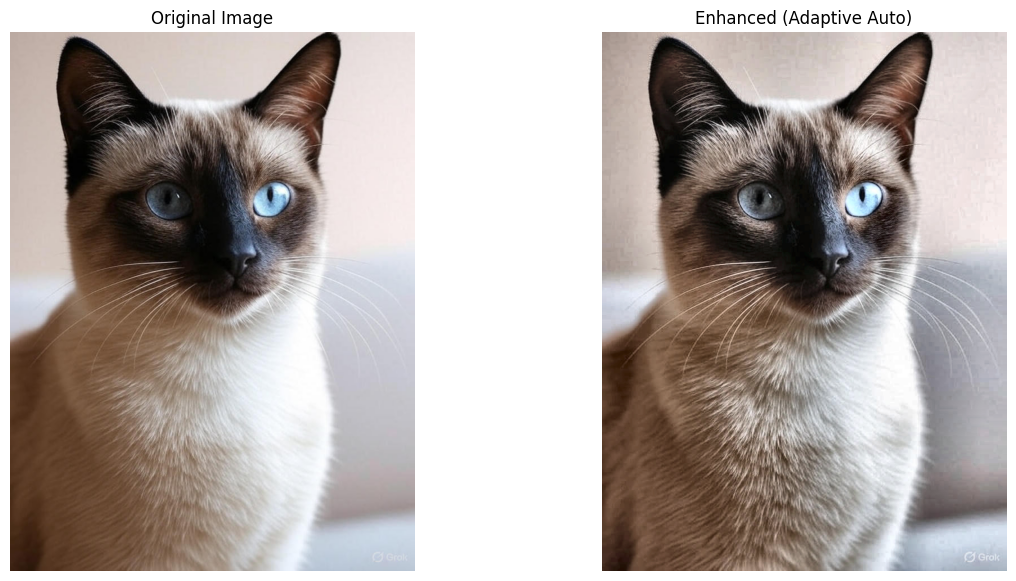

In [67]:
img_path = "assets/Image.jpeg"

original = cv2.imread(img_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

enhanced = enhance_auto_adaptive(img_path)

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(enhanced)
plt.title("Enhanced (Adaptive Auto)")
plt.axis("off")
plt.show()
